In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import sys
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

In [8]:
print(sys.executable)


c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Scripts\python.exe


In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/TripathiAshutosh/dataset/main/banking.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [12]:
df.y.value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [13]:
def data_cleaning(df):
    print("N/A values in the data")
    print(df.isna().sum())
    df = df.dropna()
    print(f'N/A after dropping the NA values -> {df.isna().sum()}')
    return df

In [15]:
df.education.value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [37]:
def preprocessing(df):
    df['education'] = np.where(df['education']=='basic.4y', 'Basic', df['education'])
    df['education'] = np.where(df['education']=='basic.6y', 'Basic', df['education'])
    df['education'] = np.where(df['education']=='basic.9y', 'Basic', df['education'])

    cat_vars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
    for var in cat_vars:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(df[var], prefix=var)
        data1=df.join(cat_list)
        df=data1
    all_column = df.columns.values.tolist()
    col_to_keep = [i for i in all_column if i not in cat_vars]

    f_df = df[col_to_keep]
    f_df.columns = f_df.columns.str.replace('.','_')
    f_df.columns = f_df.columns.str.replace(' ','_')
    return f_df

In [44]:
def train_test_split_data(df):
    X = df.loc[:, df.columns != 'y']
    y = df.loc[:, df.columns == 'y']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=43, stratify= y)
    return X_train, X_test, y_train, y_test
    

In [20]:
def over_sample(X_train, y_train):
    sm= SMOTE(random_state=0)
    col = X_train.columns
    print(f'value for each class before oversampling - {y_train.y.value_counts}')
    os_data_X ,os_data_y = sm.fit_resample(X_train,y_train)
    os_data_X = pd.DataFrame(data= os_data_X, columns=col)
    os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])
    print(f'value for each class after oversampling - {y_train.y.value_counts}')

    X_train = os_data_X
    y_train = os_data_y['y']

    return X_train, y_train



In [22]:
def basic_classifier(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=41)
    rf.fit(X_train,y_train)
    return rf

In [23]:
def predict_test(X_test, model):
    y_pred = model.predict(X_test)
    return y_pred

In [24]:
def predict_proba_test(X_test, model):
    y_pred = model.predict_proba(X_test)
    return y_pred

In [56]:
def get_metrics(y_test,y_pred,y_pred_prob):
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    cross_entropy = log_loss(y_test, y_pred_prob)

    return {'accuracy': round(acc, 2), 'precision': round(precision, 2), 'recall': round(rec, 2), 'entropy': round(cross_entropy, 2)}

In [32]:
# def create_roc_auc_plot(clf, X_data, y_data):
#     import matplotlib.pyplot as plt
#     from sklearn import metrics
#     metrics.plot_roc_curve(clf, X_data, y_data) 
#     plt.savefig('roc_auc_curve.png')


# def create_confusion_matrix_plot(clf, X_test, y_test):
#     ConfusionMatrixDisplay.from_predictions(clf, X_test, y_test)
#     plt.savefig('confusion_matrix.png')

In [77]:
def hyper_parameter_tuning(X_train, y_train):
    n_estimators = [5,21,51,101] 
    max_features = ['auto','sqrt']
    max_depth = [int(x) for x in np.linspace(10,20, num=12)]
    min_samples_split = [2,6,10]
    min_samples_leaf = [1,3,4]
    bootstrap = [True, False]

    random_grid = {
        'n_estimators':n_estimators,
        'max_features':max_features,
        'max_depth':max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }
    clf = RandomForestClassifier()
    model_tuning =RandomizedSearchCV(estimator=clf, param_distributions=random_grid,n_iter=100, cv=5, verbose=2,
                                     random_state=35, n_jobs=-1)
    
    model_tuning.fit(X_train,y_train)

    print(f'Best params after model tuning is {model_tuning.best_params_}')

    best_params = model_tuning.best_params_
    n_estimators = best_params['n_estimators']
    min_samples_split = best_params['min_samples_split']
    min_samples_leaf = best_params['min_samples_leaf']
    max_features = best_params['max_features']
    max_depth = best_params['max_depth']
    bootstrap = best_params['bootstrap']

    model_tuned = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split,
                                         min_samples_leaf= min_samples_leaf, max_features = max_features,
                                         max_depth= max_depth, bootstrap=bootstrap) 
    model_tuned.fit( X_train, y_train)
    return model_tuned,best_params
    

In [38]:
df1 = data_cleaning(df)

N/A values in the data
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64
N/A after dropping the NA values -> age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64


In [39]:
df1 = preprocessing(df)

In [41]:
df1.head()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,False,False,False,False,True,False,False,False,True,False
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,False,False,True,False,False,False,False,False,True,False
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,False,False,False,False,True,False,False,False,False,True
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,False,False,True,False,False,False,False,False,True,False
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,False,False,True,False,False,False,False,False,False,True


In [48]:
X_train, X_test, y_train, y_test = train_test_split_data(df1)
y_train.shape

(30891, 1)

In [49]:
X_train, y_train = over_sample(X_train, y_train)

value for each class before oversampling - <bound method IndexOpsMixin.value_counts of 16672    0
30166    1
38967    0
6099     0
33416    0
        ..
6142     0
38323    0
32177    0
35222    1
27765    0
Name: y, Length: 30891, dtype: int64>
value for each class after oversampling - <bound method IndexOpsMixin.value_counts of 16672    0
30166    1
38967    0
6099     0
33416    0
        ..
6142     0
38323    0
32177    0
35222    1
27765    0
Name: y, Length: 30891, dtype: int64>


In [52]:
model1 = basic_classifier(X_train,y_train)
y_pred = predict_test(X_test, model1)
y_pred_proba = predict_proba_test(X_test,model1)

In [55]:
y_pred_proba

array([[0.97560976, 0.02439024],
       [0.97560976, 0.02439024],
       [0.46341463, 0.53658537],
       ...,
       [0.97560976, 0.02439024],
       [0.97560976, 0.02439024],
       [0.2195122 , 0.7804878 ]])

In [57]:
all_metrics = get_metrics(y_test, y_pred, y_pred_proba)
print(all_metrics)

{'accuracy': 0.91, 'precision': 0.62, 'recall': 0.55, 'entropy': 0.22}


## MLFlow 

In [58]:
experiment1 = 'Training_basic_classifier'
run_name = 'check_term_deposit'

In [83]:
def create_mlflow_experiment(experiment1, run_name, model, all_metrics, confusion_mat_path=None, roc_auc_path=None
                             ,run_params=None):
    mlflow.set_experiment(experiment1)

    with mlflow.start_run(run_name=run_name):
        if not run_params is None:
            for params in run_params:
                mlflow.log_param(params, run_params[params])

        for metric in all_metrics:
            mlflow.log_metric(metric, all_metrics[metric])
        mlflow.sklearn.log_model(model, "model")

        if not confusion_mat_path == None:
            mlflow.log_artifact(confusion_mat_path, 'confusion_materix')
            
        if not roc_auc_path == None:
            mlflow.log_artifact(roc_auc_path, "roc_auc_plot")

        mlflow.set_tag("tag1", "Random Forest")
        mlflow.set_tags({"tag2":"Randomized Search CV", "tag3":"Production"})

    print('Run - %s is logged to Experiment - %s' %(run_name, experiment1))
        

In [73]:
create_mlflow_experiment(experiment1,run_name,model1, all_metrics, 'confusion_matrix.png', 'roc_auc_curve.png')

Run - check_term_deposit is logged to Experiment - Training_basic_classifier


In [67]:
for metric in all_metrics:
    print(metric)
    print(all_metrics[metric])
    print('\n')

accuracy
0.91


precision
0.62


recall
0.55


entropy
0.22




In [78]:
experiment2 = 'classifier with best params'
run_name = 'term_depo_best'
model2 = hyper_parameter_tuning(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
182 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\sklearn\base.py", line 666, in _vali

Best params after model tuning is {'n_estimators': 21, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': False}


AttributeError: 'tuple' object has no attribute 'predict'

In [79]:
model2

(RandomForestClassifier(bootstrap=False, max_depth=15, n_estimators=21),
 {'n_estimators': 21,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 15,
  'bootstrap': False})

In [82]:
y_pred2 = predict_test(X_test, model2[0])
y_pred_proba2 = predict_proba_test(X_test, model2[0])
all_metrics2 = get_metrics(y_test, y_pred2, y_pred_proba2)

In [84]:
create_mlflow_experiment(experiment2,run_name,model2[0], all_metrics2, 'confusion_matrix.png', 'roc_auc_curve.png')

2024/03/17 17:32:06 INFO mlflow.tracking.fluent: Experiment with name 'classifier with best params' does not exist. Creating a new experiment.


Run - term_depo_best is logged to Experiment - classifier with best params


c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\sriva\OneDrive\Desktop\MLflow\mlflowenv\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


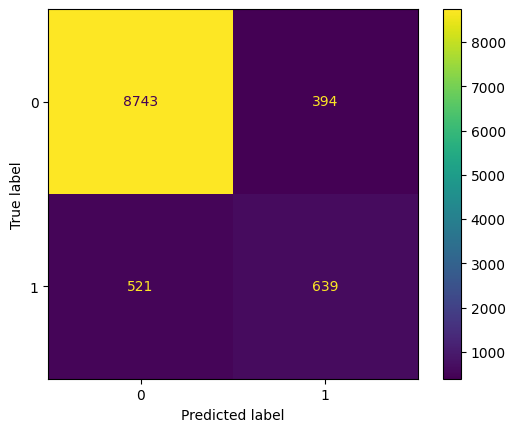

In [87]:
cm = ConfusionMatrixDisplay.from_estimator(model1, X_test, y_test)